<h1><center>Example code for ROC & AUC for a Logisitic Regression Model </center></h1>

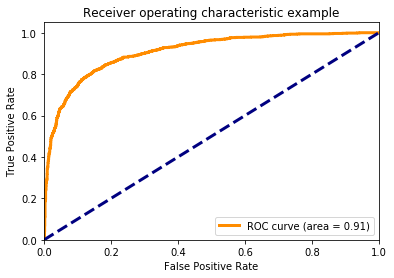

In [50]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
import re
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import requests
import io

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Reading .csv file

# Training csv file
url_train = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-train.csv"
csv_train = requests.get(url_train).content
df_train = pd.read_csv(io.StringIO(csv_train.decode('utf-8')))

# Testing csv file
url_test = "https://raw.githubusercontent.com/SoniaLei/nlp-web-scrapping/development/data/raw/tweets-test.csv"
csv_test = requests.get(url_test).content
df_test = pd.read_csv(io.StringIO(csv_test.decode('utf-8')))

X_train = df_train['text'].astype(str)
y_train = df_train['sentiment'].astype(str)

# Binarize the output
y_train = label_binarize(y_train, classes=['negative', 'neutral', 'positive'])

n_classes = Y_train.shape[1]

X_test = df_test['text'].astype(str)
y_test = df_test['sentiment'].astype(str)

# Binarize the output
y_test = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Creating custom cleaner function

Lemmatiser = nltk.stem.WordNetLemmatizer()
# Instantiating the NLTK Lemmatiser

punctuations = string.punctuation
# Putting punctuation symbols into an object

nlp = spacy.load("en_core_web_sm")
# Import spacy model

stopwords = spacy.lang.en.stop_words.STOP_WORDS
# A list of stopwords that can be filtered out
    # NLTK also has a stop words object but it has fewer words

def text_cleaner(sentence):    
                
    sentence = "".join([char for char in sentence.strip() if char not in punctuations])
    # Getting rid of any punctuation characters
    
    myTokens = re.split('\W+', sentence)
    # Tokenising the words
    
    myTokens = [token.lower() for token in myTokens if token not in stopwords]
    # Removing stop words
    
    myTokens = [Lemmatiser.lemmatize(token) for token in myTokens]
    # Lemmatising the words and putting in lower case except for proper nouns
    
    return myTokens 

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Creating Bag-of-Words Vectoriser

tfidf_vector = TfidfVectorizer(tokenizer = text_cleaner)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Building OVR Logisitic Regression Classifier

LogReg = LogisticRegression(max_iter=1000)

ovr = OneVsRestClassifier(LogReg)

pipe = Pipeline([('vectorizer', tfidf_vector)
                 ,('classifier', ovr)])

pipe.fit(X_train, y_train)

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

                        # Build the ROC and show AUC

# Learn to predict each class against the other
y_score = pipe.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
lw = 3
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()